In [1]:
from model import SirenImageLearner, SirenImageDataWrapper

import math
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl

from torchvision.transforms import ToTensor, ToPILImage

from loguru import logger
import matplotlib.pyplot as plt
import PIL
import tqdm

# fuck it...
DEVICE = 'cuda'

In [2]:
im_path = '../data/google-photos-export/uncompressed/takeout-20210901T023707Z-001/Takeout/Google Photos/lithophane candidates/20210313_133327.jpg'
im = PIL.Image.open(im_path)
im3 = im.resize((122, 163)).convert('L').rotate(-90, expand=True)
t_im3 = ToTensor()(im3).squeeze()

from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger, WandbLogger

#wandb_logger = WandbLogger()
tb_logger = TensorBoardLogger("tb_logs", name="siren-upsample")

model = SirenImageLearner(notebook_mode=True)
dm = SirenImageDataWrapper(target_image=t_im3)

# https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html#trainer-flags
trainer = pl.Trainer(
    gpus=-1,
    max_steps=1000,
    #max_steps=100000, # I think there's a way to use CLI args to override here
    log_every_n_steps=100, #50,
    logger=tb_logger,
    log_gpu_memory=True, # fuck yeah!
    weights_summary=None,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: -1it [00:00, ?it/s]

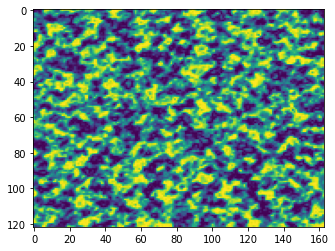

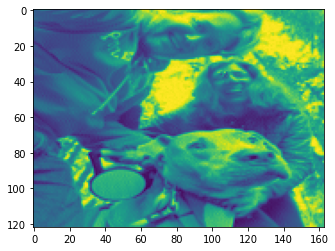

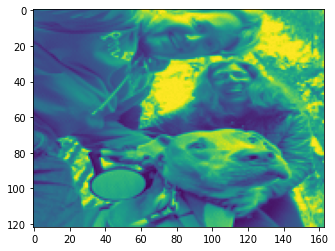

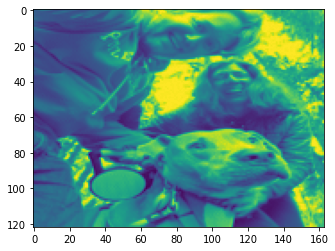

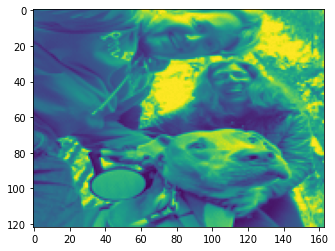

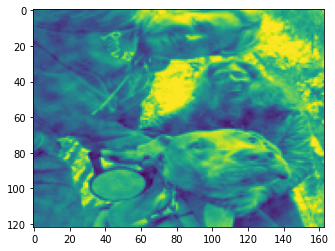

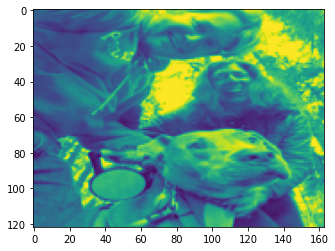

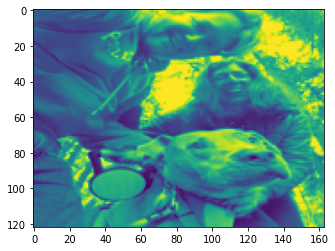

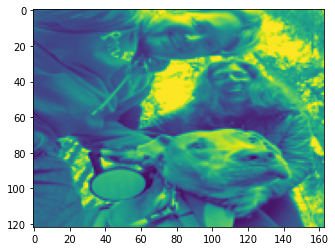

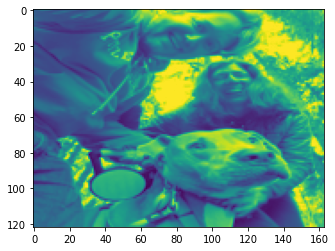

In [3]:
trainer.fit(model, dm)

In [4]:
# To do: experiment with regularization

# To do: WandB logging?

# To do: hparams parallel coords? wandb have this already? 
# Maybe easier with MLFlow logging to local db serving a custom dashboard

In [5]:
# Quantile approximation for distributional similarity

import numpy as np

t_im3.shape # 122, 163
t_rand = torch.rand(t_im3.shape)
n_quantiles = 100

# I like the idea of taking random quantiles like this, but I think it complicates
# the integral approximation. If quantiles are evenly spaced, I can just sum. 
# otherwise, I think I need to factor in the dx
##q = torch.rand(n_quantiles).sort().values
#q = torch.linspace(0,1,steps=n_quantiles)

#p0 = t_im3.quantile(q).numpy()
#p1 = t_rand.quantile(q).numpy()
#q = q.numpy()
#d = np.abs(p0-p1)

def q_q_distance(t0, t1, n_quantiles=100):
    q = torch.linspace(0,1,steps=n_quantiles+1)[:-1]
    p0 = t0.quantile(q)
    p1 = t1.quantile(q)
    d = math.sum(math.abs(p0-p1))
    return d

In [6]:
plt.scatter(q, p0)
plt.scatter(q, p1)
plt.show()


plt.scatter(q, d)
plt.show()

NameError: name 'q' is not defined

In [ ]:
d.sum()

In [ ]:
 # not identical
p0[0], p1[0], p0[-1], p1[-1] # ends up being the max, basically identical